# Syncing spike data with pycontrol

In [91]:
%reload_ext autoreload
%autoreload 2

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matplotlib.pylab as plt 
from tqdm.auto import tqdm
from trialexp.process.pyphotometry.utils import *
from trialexp.utils.ephys_utilities import create_sync_photo_ephys
import pandas as pd 
import xarray as xr
from trialexp.process.pycontrol import event_filters
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [92]:
sel_probe = 'ProbeB'

In [93]:
base = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin')
# path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/sorting')
path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/ephys/sorting')
path

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/ephys/sorting')

In [94]:
path.parents[1]

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254')

In [95]:
figure_output = path.parents[1]/'processed'/'figures'/'ephys'
figure_output

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/processed/figures/ephys')

In [96]:
# Manualliy find the correct timestamp file for now
rec_properties = pd.read_csv(path.parent/'rec_properties.csv')
rec_properties.sync_path.iloc[2]

# Manually get the start time for now
# TODO: fix the bug in create_folder
tstart = rec_properties[rec_properties.longest==True].tstart.iloc[0]
tstart

2336.4272

## Attempt to load the channel position from raw kilosort output


In [97]:
koutput_folder = path/'output'/sel_probe

In [98]:
templates = np.load(koutput_folder/'templates.npy')
templates.shape

(963, 82, 384)

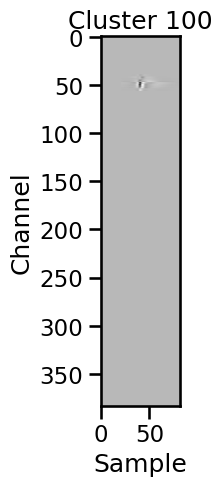

In [99]:
cluster_id = 100
plt.imshow(templates[cluster_id,:,:].T, cmap='gray');
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title(f'Cluster {cluster_id}');

In [100]:
peak_amp = np.max(abs(templates), axis=1)
channel_idx = np.argmax(peak_amp, axis=1)

# Data sync

In [101]:
#load and create the sync object
# sync to photometry data for now, but later probably should sync everything back to pycontrol

photo_file = list((path.parents[1]/'pyphotometry').glob('*.ppd'))[0]
photo_data = import_ppd(photo_file)
photo_time = photo_data['pulse_times_2']
# rsync = create_sync_photo_ephys(photo_time, path.parent/'correct')
rsync = create_sync_photo_ephys(photo_time, path.parent)
assert rsync is not None

In [102]:
#load the spike extractor
probe_sorting = si.load_extractor(path/sel_probe)

### Calculate depth of each channel

Text(0, 0.5, 'Channel')

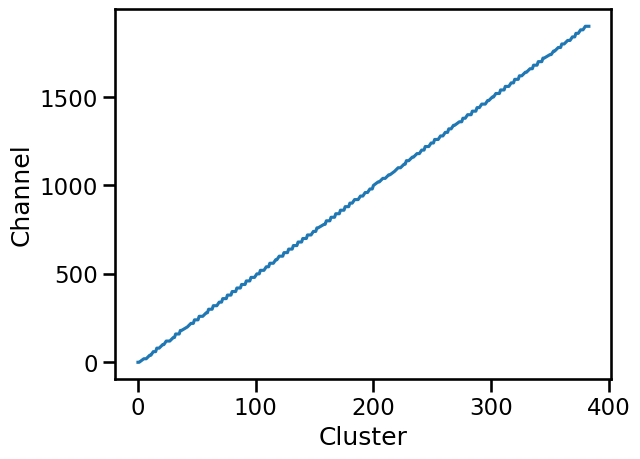

In [103]:
# rearrange the unit id such that they are in the same order as channel
# For each cluster, get its corresponding dominant channel
# then from the dominant channel number, we can calculate its depth, each row has 4 contact, and each row is 20um high
unit_ids = probe_sorting.get_unit_ids()
idx = np.argsort(channel_idx)
unit_ids_sorted = unit_ids[idx] #
chan_idx_sorted = channel_idx[idx]
cluster_depth = chan_idx_sorted//4*20
plt.plot(chan_idx_sorted, cluster_depth)
plt.xlabel('Cluster')
plt.ylabel('Channel')

In [104]:
# Sync and  all the sorting to ms
# spike time from kilosort count from the beginning of the recording
# where the rsync time count from the beginning of the open ephys session
# so we need to shift the spike time to the ephys rsync time unit first

def get_sorting_spiketime(sorting,rsync,tstart, Fs=30000):
    spike_times = []
    max_time = 0
    for id in tqdm(unit_ids_sorted):
        ks_label = probe_sorting.get_unit_property(id, 'KSLabel') # for future
        spk_time = probe_sorting.get_unit_spike_train(id)
        spk_time = (spk_time/Fs+tstart)*1000 #need to shift by the starting time of recording
        spk_time = rsync.A_to_B(spk_time)

        if len(spk_time)>0:
            max_time = max(max_time, spk_time[-1])
        spike_times.append(spk_time)
    return spike_times

spike_times = get_sorting_spiketime(probe_sorting, rsync, tstart)
print(len(spike_times))

  0%|          | 0/963 [00:00<?, ?it/s]

963


In [105]:
# load xarray data and use that to bin the firing rate
xr_session = xr.load_dataset(path.parents[1]/'processed'/'xr_session.nc')

In [106]:
# convert spike timing to firing rate
def calculate_spike_rate(spike_times, bins, bin_size):
    spike_rates = np.zeros((len(bins)-1, len(spike_times)))
    for i in tqdm(range(len(spike_times))):
        count, _ = np.histogram(spike_times[i], bins) 
        spike_rates[:,i] = count * (1000/bin_size)
    return spike_rates

bin_size = 50
bins = np.append(xr_session.time.data, xr_session.time.data[-1]+50) # make sure we cover the whole range

spike_rates = calculate_spike_rate(spike_times, bins, bin_size)


  0%|          | 0/963 [00:00<?, ?it/s]

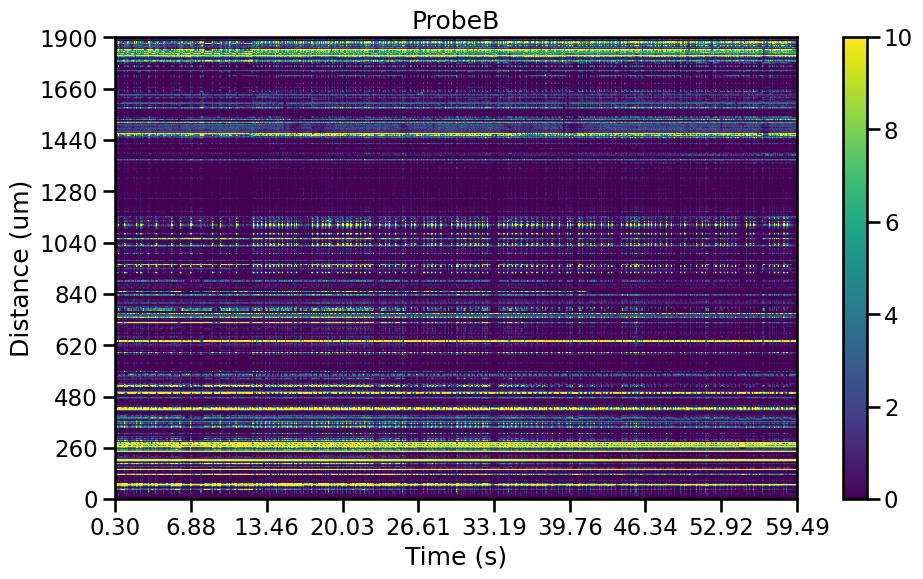

In [107]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.imshow(spike_rates.T, vmax=10)
plt.colorbar()
ax.set_aspect(50)

xticks = np.linspace(0,spike_rates.shape[0],10).astype(int)
ax.set_xticks(xticks);
labels = [f'{x:.2f}' for x in bins[xticks]/1000/60]
ax.set_xticklabels(labels);

yticks = np.linspace(0,spike_rates.shape[1]-1,10).astype(int)

ax.set_yticks(yticks)
ax.set_yticklabels(cluster_depth[yticks])

ax.set_ylabel('Distance (um)');
ax.set_xlabel('Time (s)')
ax.invert_yaxis()
ax.set_title(sel_probe)
plt.savefig(figure_output/f'{sel_probe}_time_all.png', dpi=300)

In [108]:
cluster_ids = probe_sorting.get_unit_ids()
xa_spike_rate = xr.DataArray(
    spike_rates, coords={'time':bins[:-1], 
                         'cluster_id':cluster_ids},
    dims=('time','cluster_id'))

xr_session['spike_rate'] = xa_spike_rate

## Align spike data to events

In [109]:
df_pycontrol = pd.read_pickle(path.parents[1]/'processed'/'df_pycontrol.pkl')
rsync_time = df_pycontrol[df_pycontrol.name=='rsync'].time
pyphoto_aligner = Rsync_aligner(pulse_times_A= rsync_time, 
                pulse_times_B= photo_time, plot=False) #align pycontrol time to pyphotometry time


In [110]:
df_event = pd.read_pickle(path.parents[1]/'processed'/'df_events_cond.pkl')
trial_window = df_event.attrs['trial_window']
dataset = xr_session.copy()

In [111]:
trigger = df_event.attrs['triggers'][0]
event_time_coord = dataset.event_time
sampling_rate = dataset.attrs['sampling_rate']/bin_size #the data has already been downsampled
add_event_data(df_event, event_filters.get_first_event_from_name,
               trial_window, pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', trigger, sampling_rate,
               filter_func_kwargs={'evt_name':trigger}, 
               time_tolerance=bin_size, 
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(198, 120, 963)


In [112]:
add_event_data(df_event, event_filters.get_first_bar_off, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_bar_off', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(198, 120, 963)


In [113]:
add_event_data(df_event, event_filters.get_first_spout, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_spout', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(198, 120, 963)


In [114]:
dataset.to_netcdf(path.parents[1]/'processed'/f'xr_spikes_{sel_probe}.nc', engine='h5netcdf')

In [157]:
def align_peak(x):
    # Align the data according to peak location
    if x.ndim==3:
        x = np.nanmean(x,axis=0)
    maxidx = np.argmax(x,axis=0)
    idx = np.argsort(maxidx)
    
    return x[:,idx], idx

def plot_rate_map(rates,xticklabels, ylabel, vline_x, nxsticks=10, do_align_peak=False, sort_idx=None):
    
    if do_align_peak:
        #align the peak first before plotting
        if sort_idx is None:
            rates,sort_idx = align_peak(rates)
        else:
            rates = rates[:, sort_idx]

    # rate is assumed to be a 2D array in the shape (time x channel)
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    plt.imshow(rates.T, vmax=10)
    plt.colorbar()
    ax.set_aspect(0.1)
    
    # figure out the correct tick label
    
    xticks = np.linspace(0,rates.shape[0]-1,nxsticks).astype(int)
    ax.set_xticks(xticks);
    labls = np.array([f'{x:.2f}' for x in xticklabels])
    ax.set_xticklabels(labls[xticks]);
    
    if align_peak:
        ax.set_yticks([])
    else:
        yticks = np.linspace(0,rates.shape[1]-1,10).astype(int)
        ax.set_yticks(yticks)
        ax.set_yticklabels(cluster_depth[yticks])
    
    ax.invert_yaxis()
    ax.set(xlabel='Time (s)', ylabel=ylabel)

    # find the cloest match 0 point
    zero_pt = np.argmin(abs(vline_x-xlabels))
    ax.axvline(zero_pt,color='w')
    if do_align_peak:
        return fig,ax,sort_idx
    else:
        return fig, ax

def plot_rate_map2(rates,xticklabels, ylabel, vline_x, ax, nxsticks=10):
    # rate is assumed to be a 2D array in the shape (time x channel)
    ax.imshow(rates.T, vmax=10)
    ax.set_aspect(0.1)
    
    # figure out the correct tick label
    
    xticks = np.linspace(0,rates.shape[0]-1,nxsticks).astype(int)
    ax.set_xticks(xticks);
    labls = np.array([f'{x:.2f}' for x in xticklabels])
    ax.set_xticklabels(labls[xticks]);
    
    yticks = np.linspace(0,rates.shape[1]-1,10).astype(int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(cluster_depth[yticks])
    
    ax.invert_yaxis()
    ax.set(xlabel='Time (s)', ylabel=ylabel)

    # find the cloest match 0 point
    zero_pt = np.argmin(abs(vline_x-xlabels))
    ax.axvline(zero_pt,color='w')
    return fig, ax

xlabels = np.round(dataset.event_time.data/100)*100/1000 #round to the nearest 10ms

## Single trial data

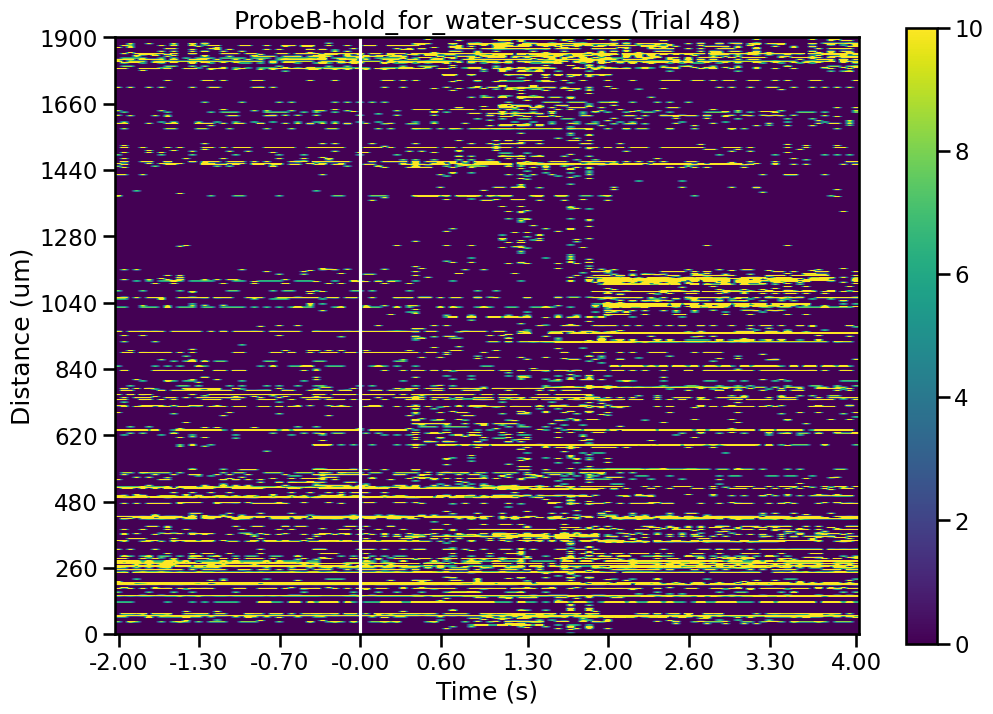

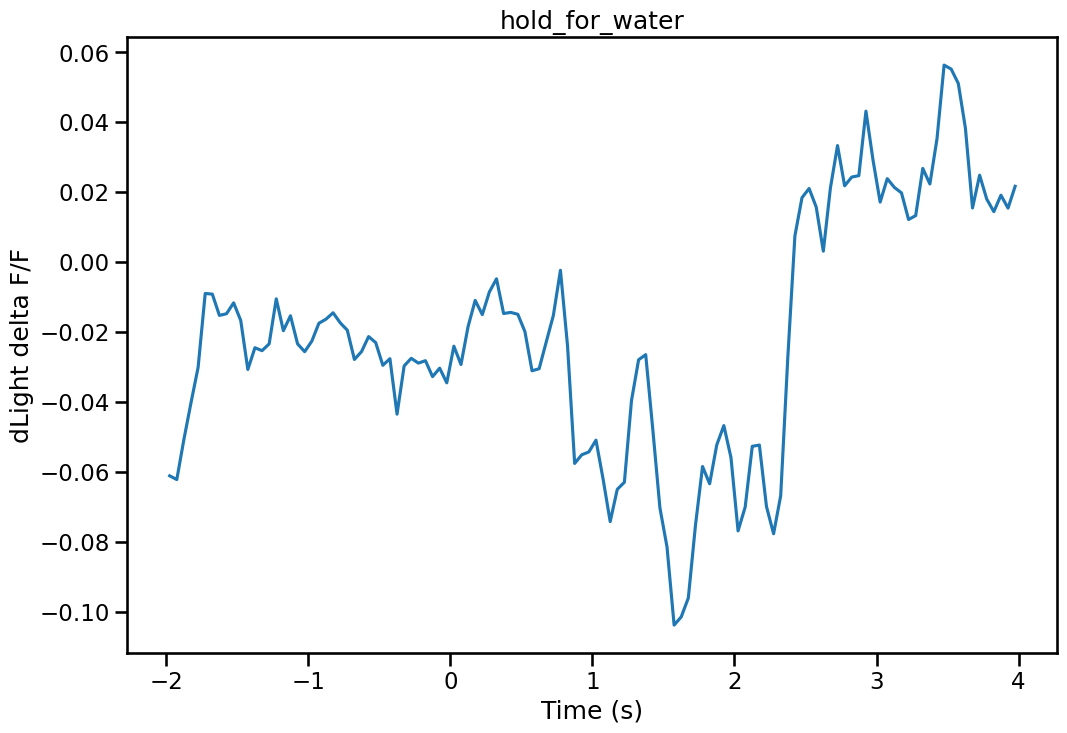

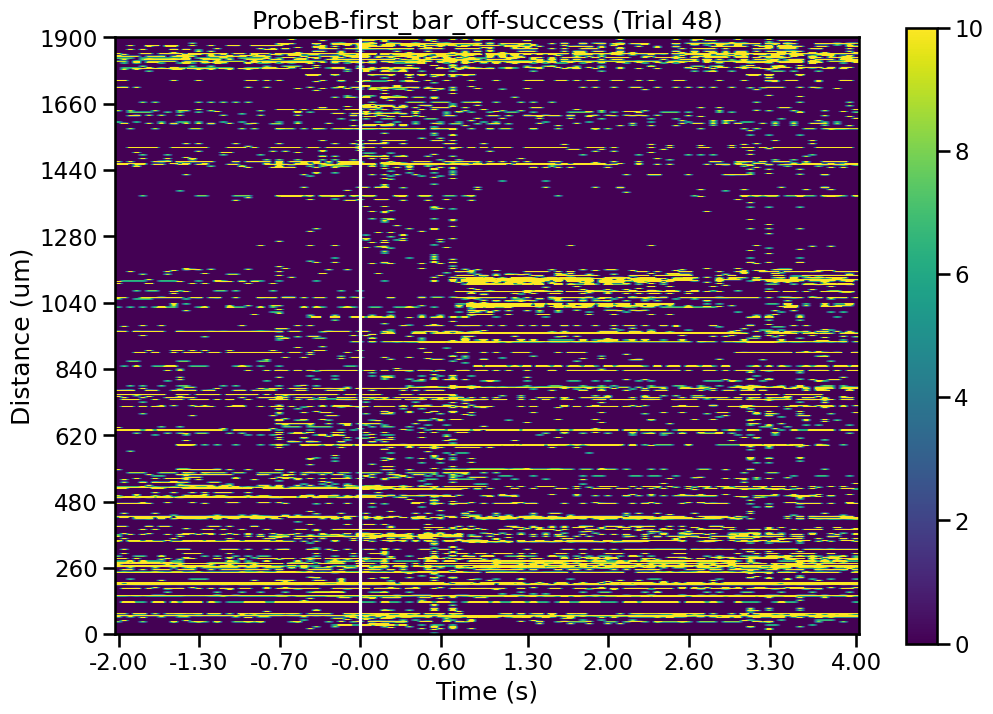

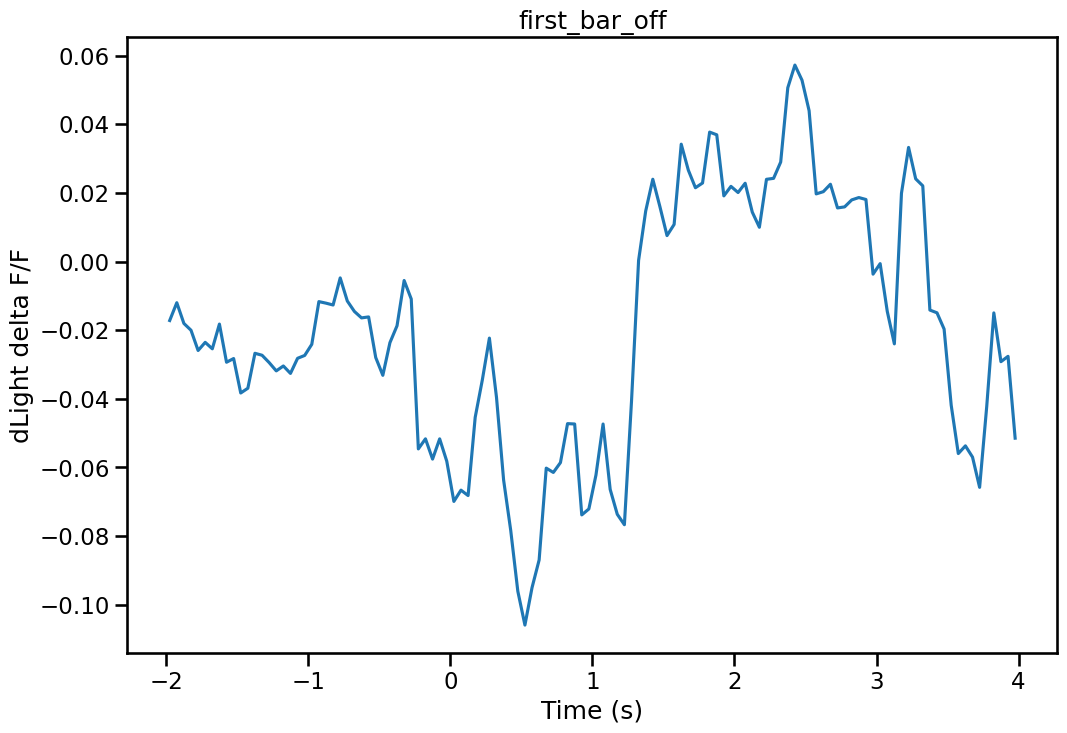

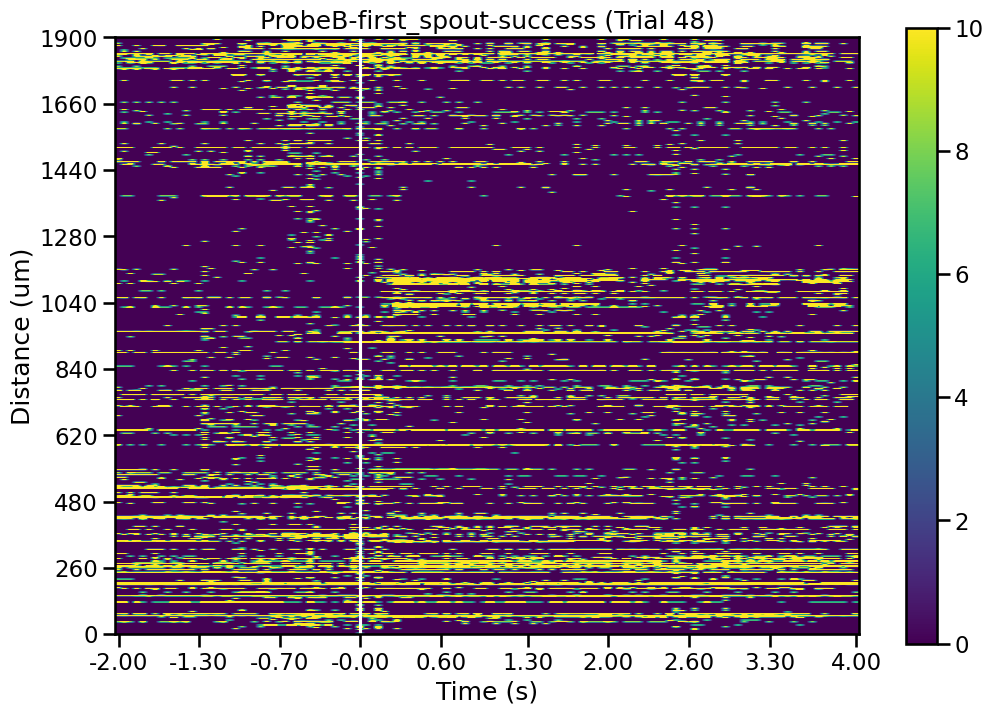

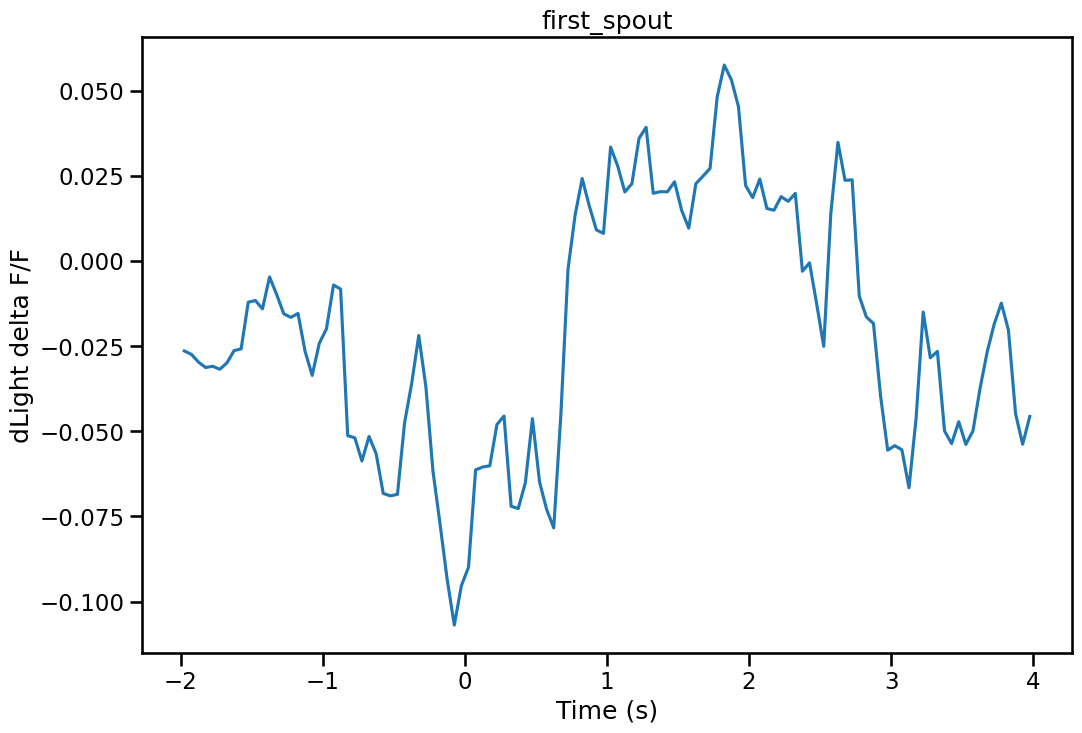

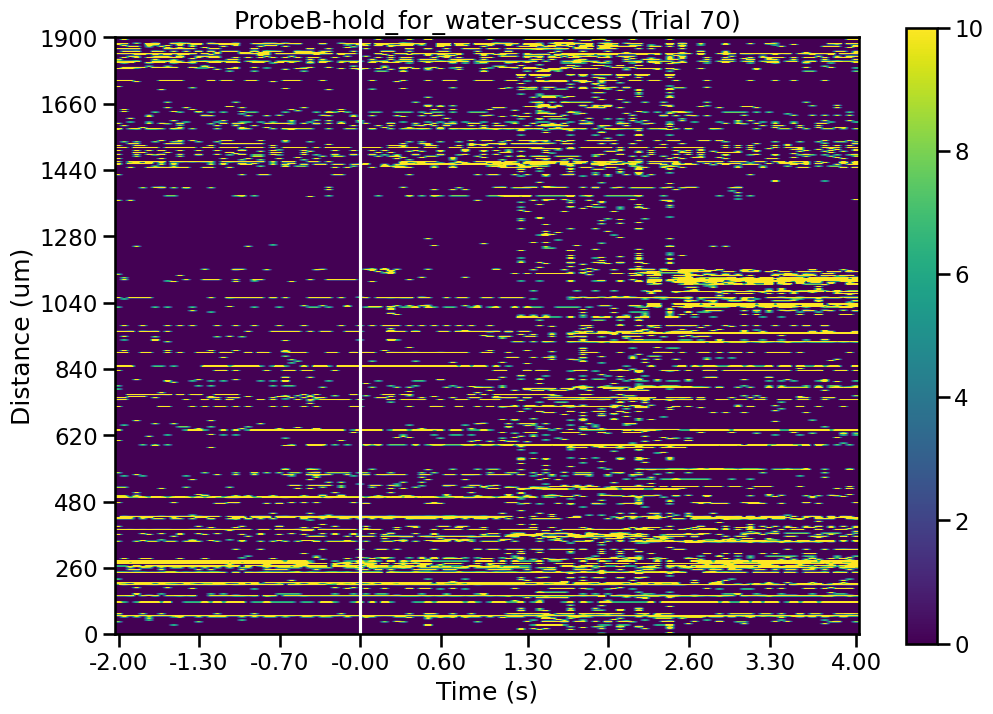

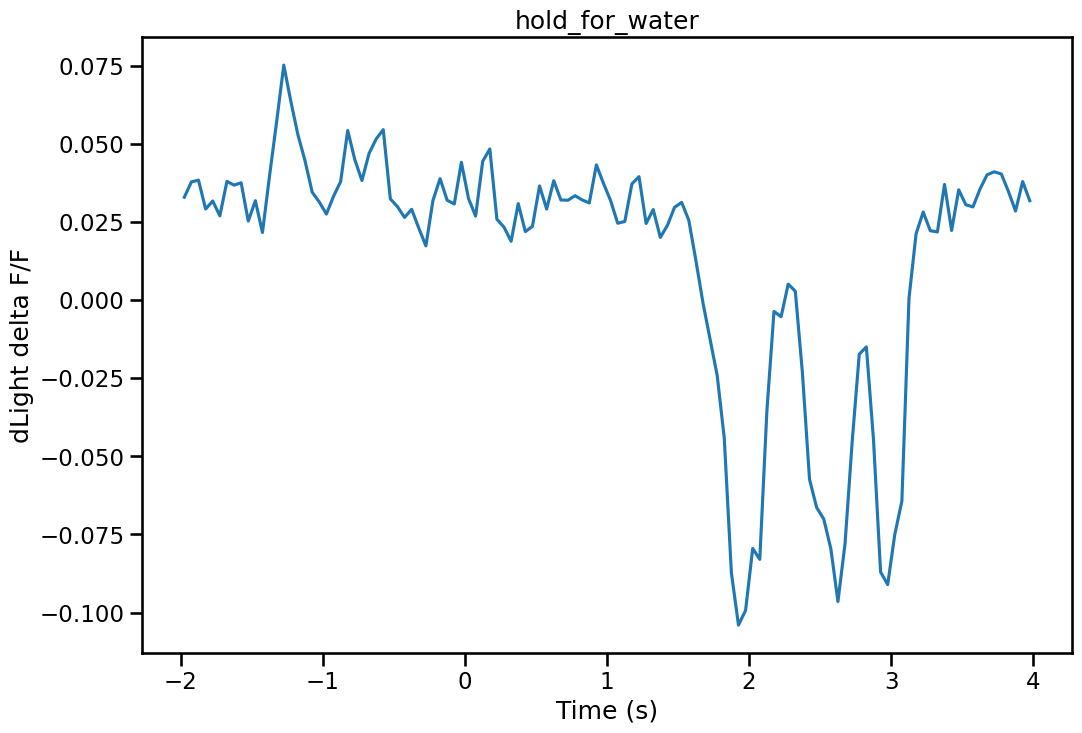

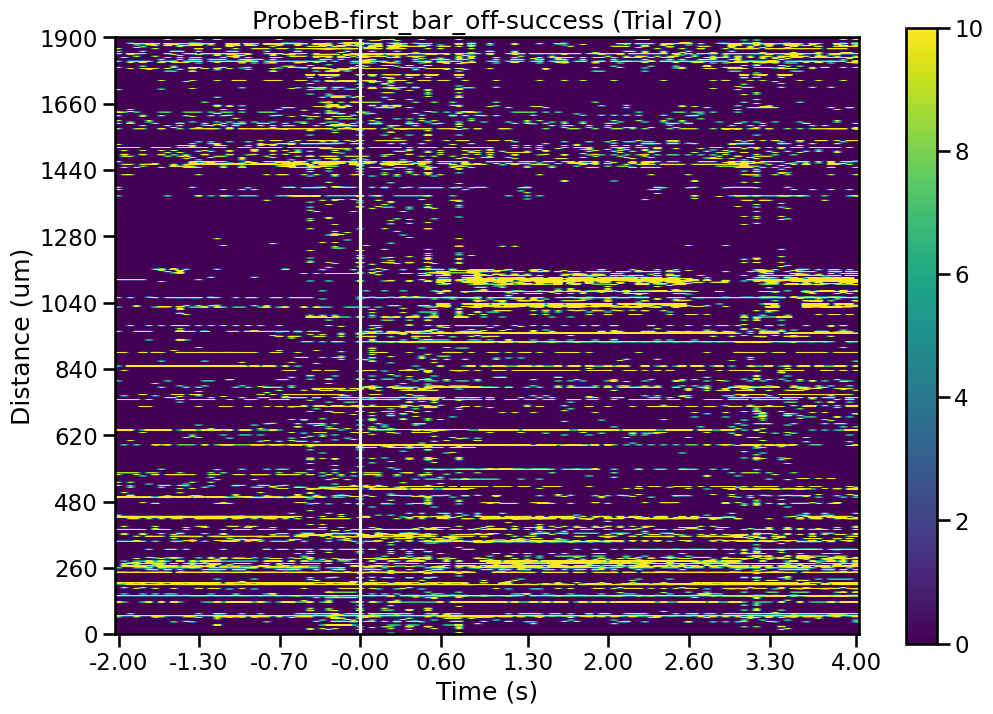

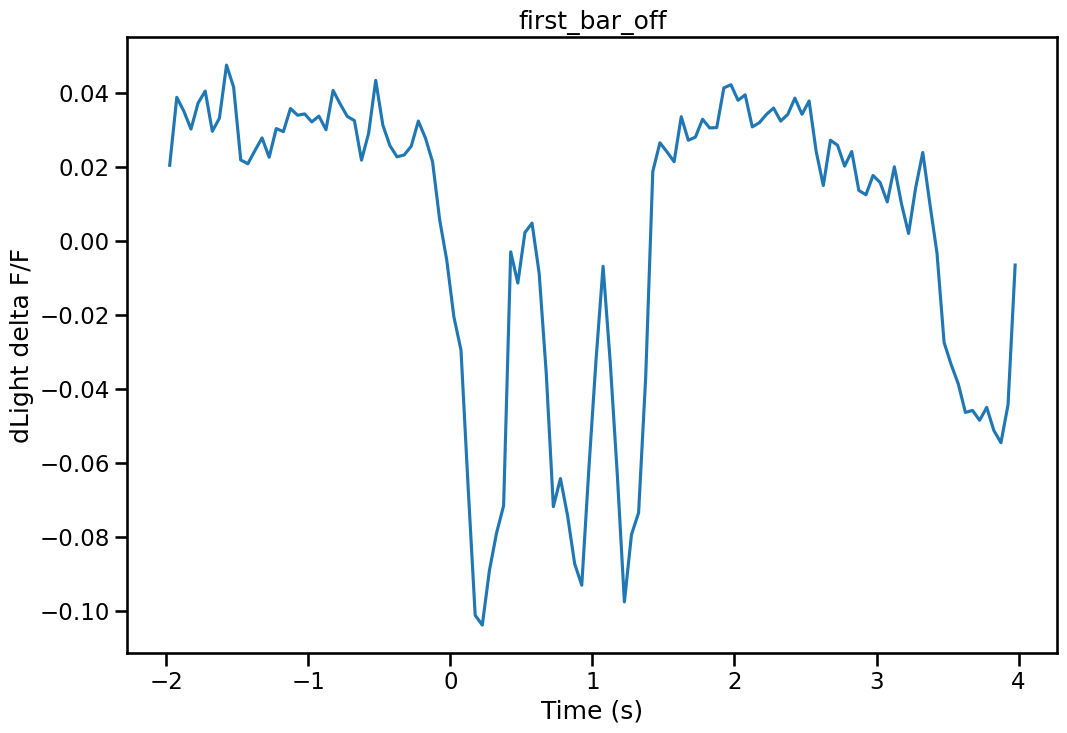

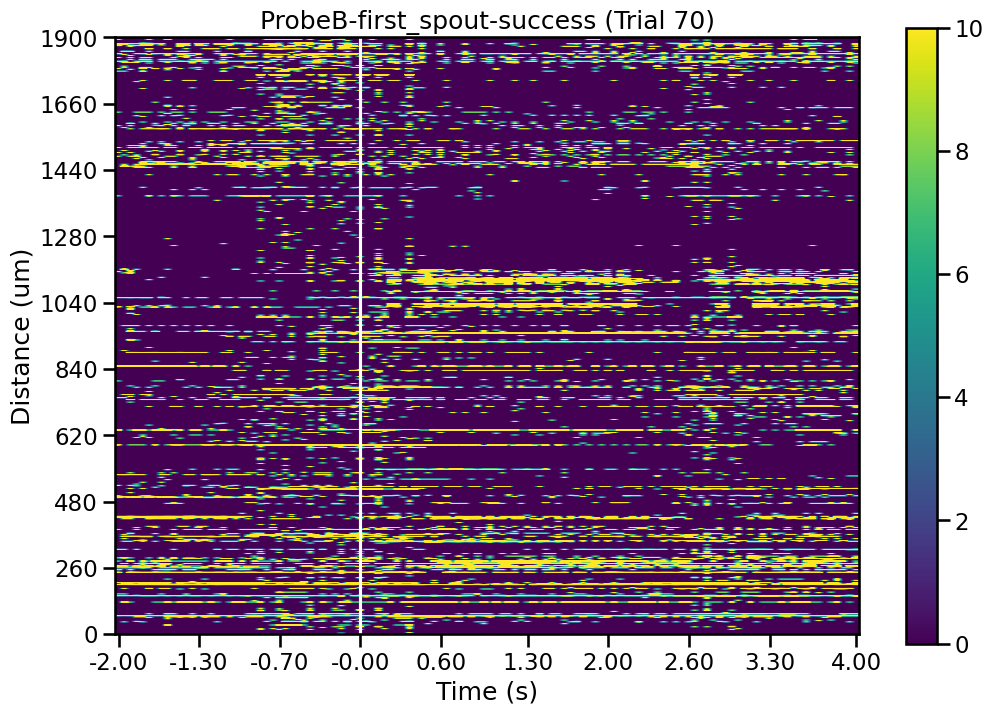

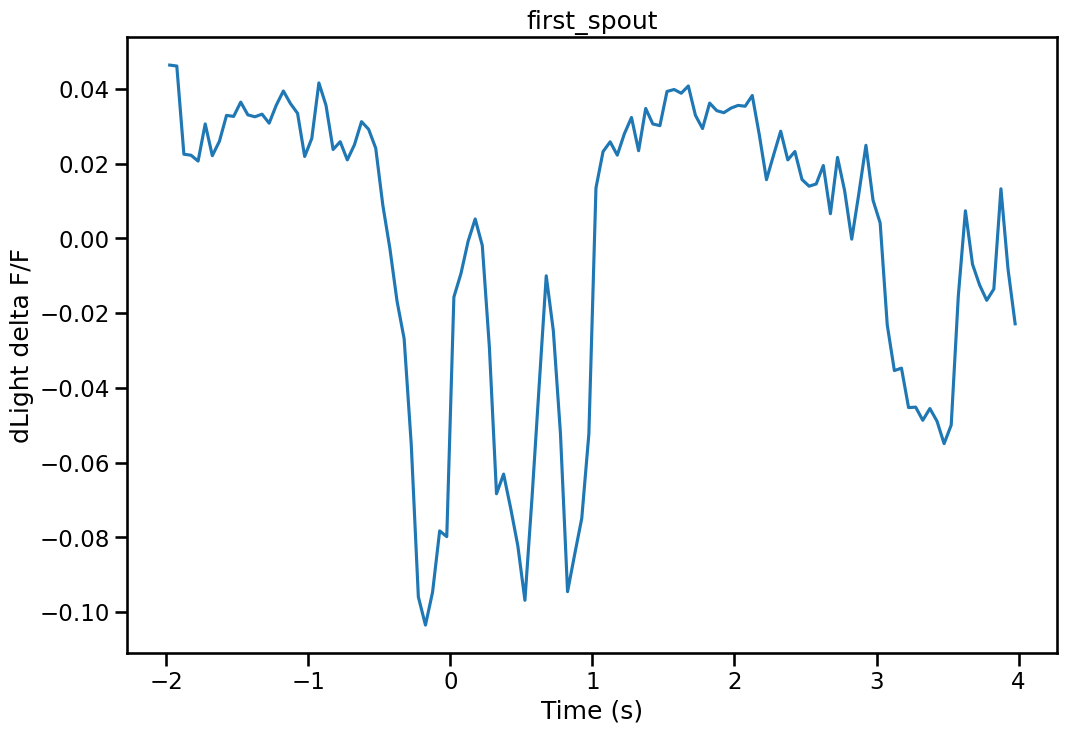

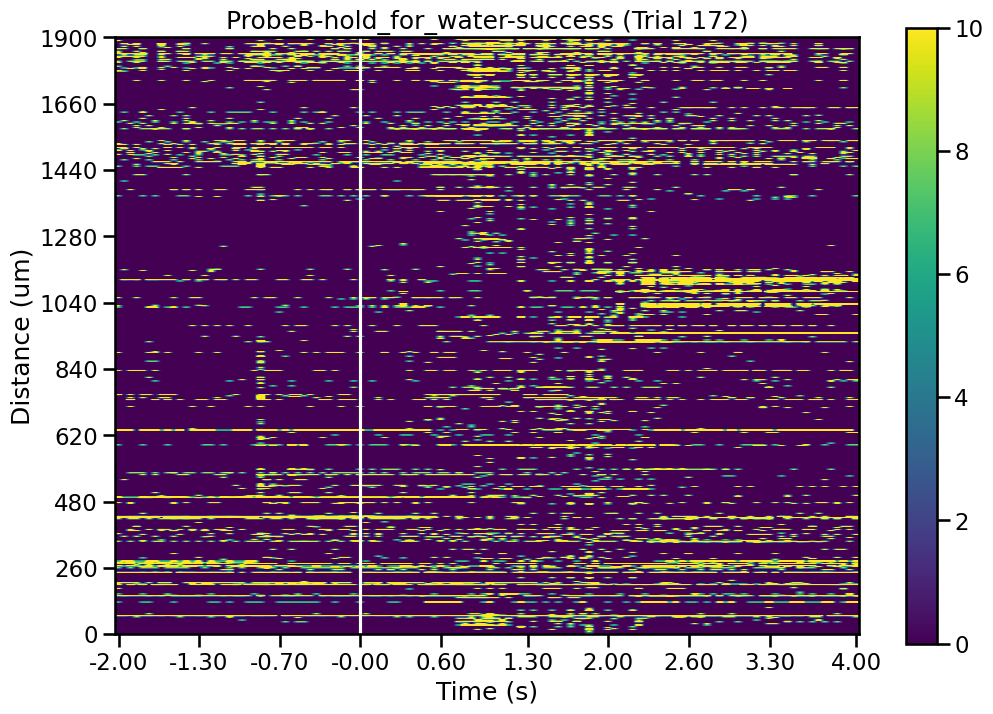

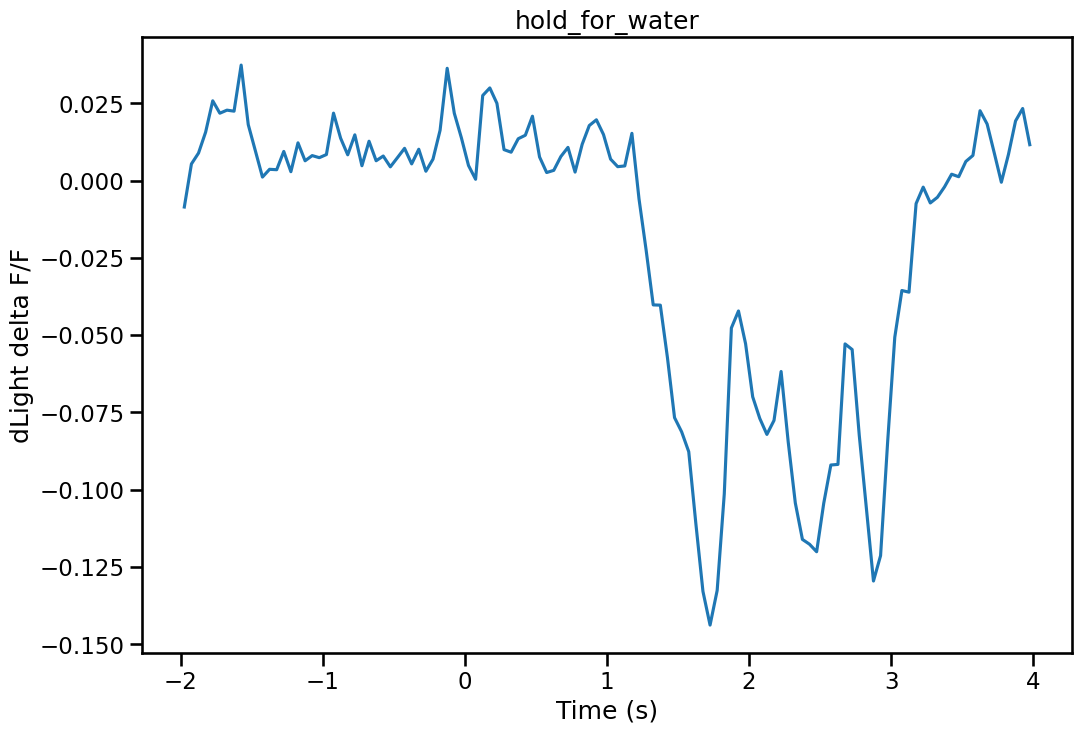

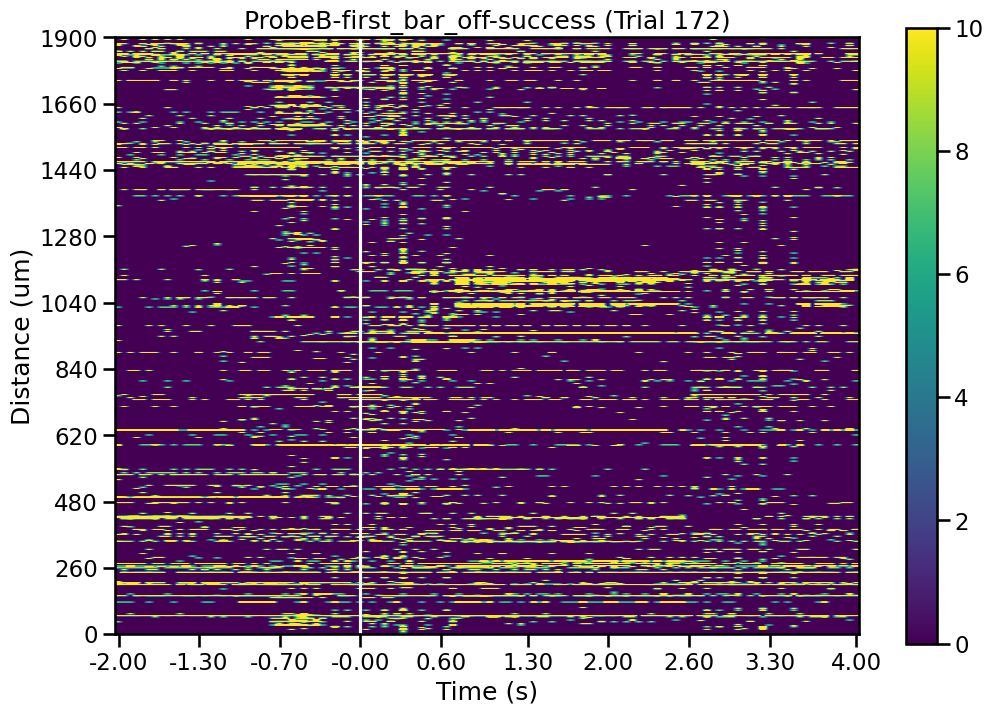

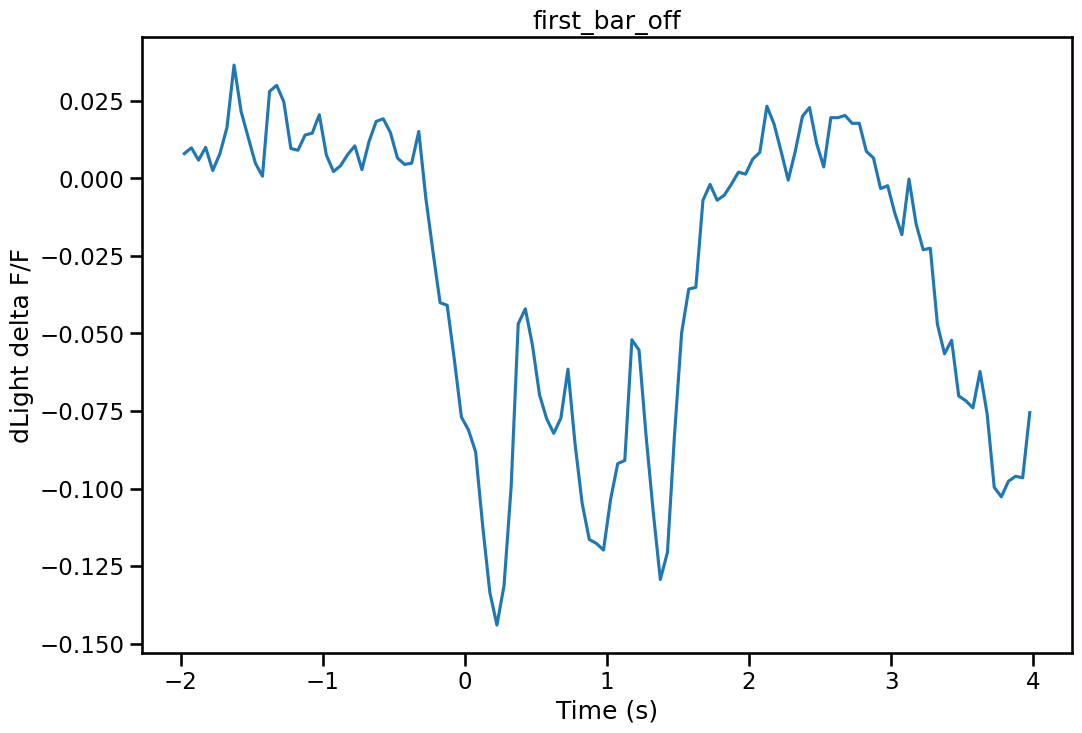

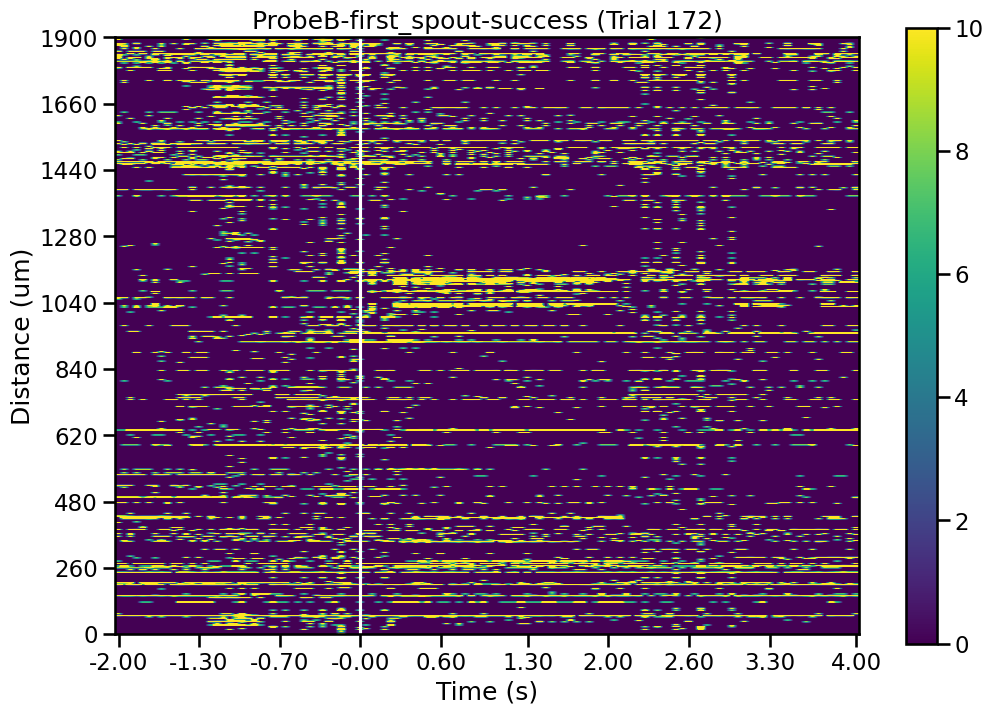

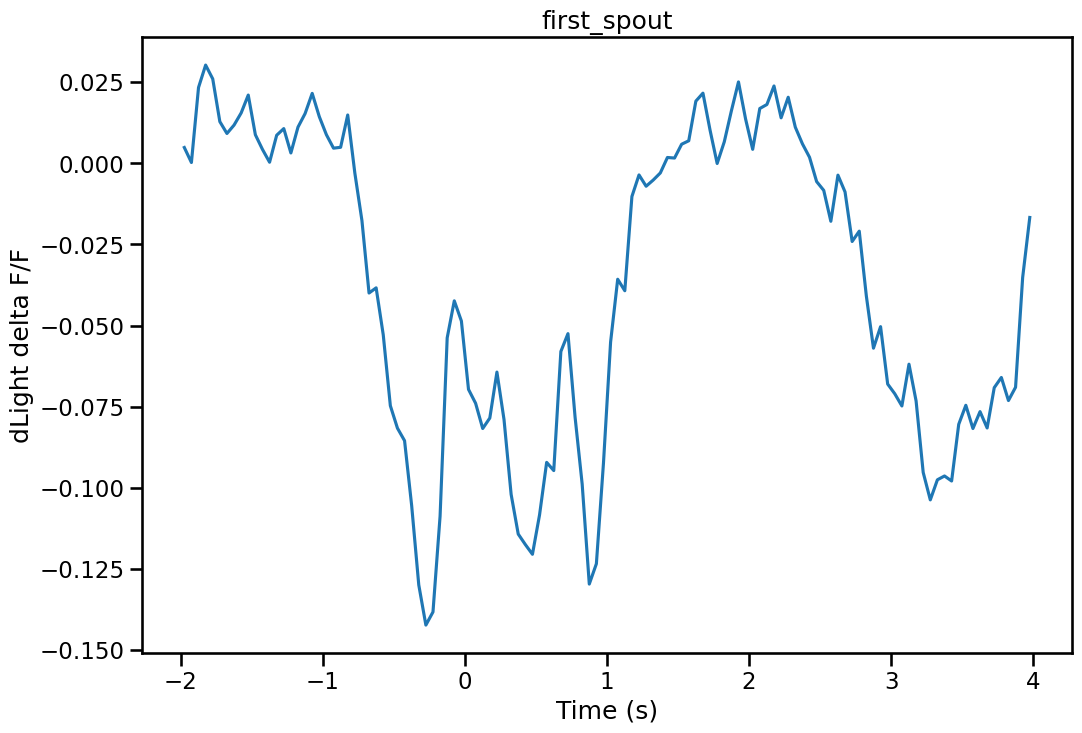

In [129]:
var2plot = ['hold_for_water', 'first_bar_off', 'first_spout']
trial_nos = [48,70,172]
is_save = True
for trial_no in trial_nos:
    for v in var2plot:
        fig, ax = plot_rate_map(dataset[v+'_spike_rate'].data[trial_no,:,:], xlabels, 'Distance (um)',  0)
        success = dataset.success[0,trial_no]
        if success:
            success_text = 'success'
        else:
            success_text = 'failed'

        ax.set_title(sel_probe+f'-{v}-{success_text} (Trial {trial_no})')
        if is_save:
            fig.savefig(figure_output/f'{sel_probe}_{v}_trial_{trial_no}.png', dpi=300)


        #also plot the dlight signal for comparison
        dlight = dataset[v+'_analog_1_df_over_f'][0, trial_no, :]
        fig,ax = plt.subplots(1,1,figsize=(12,8))
        sns.lineplot(x=dataset.event_time/1000, y=dlight,ax=ax)
        ax.set_title(v)
        ax.set(ylabel='dLight delta F/F', xlabel='Time (s)');

        if is_save:
            fig.savefig(figure_output/f'dlight_{v}_trial_{trial_no}.png', dpi=300)

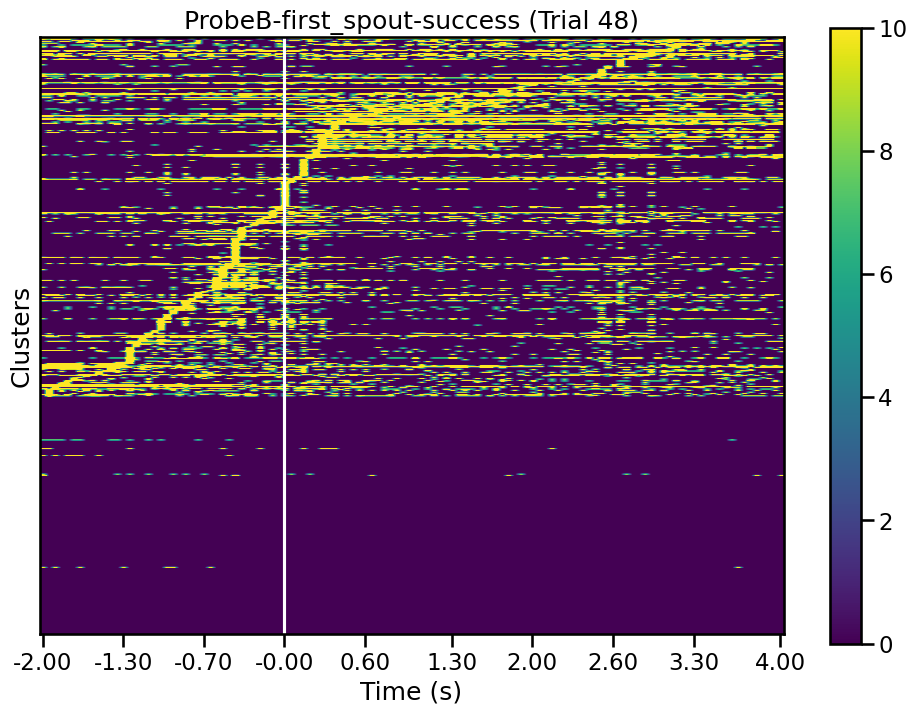

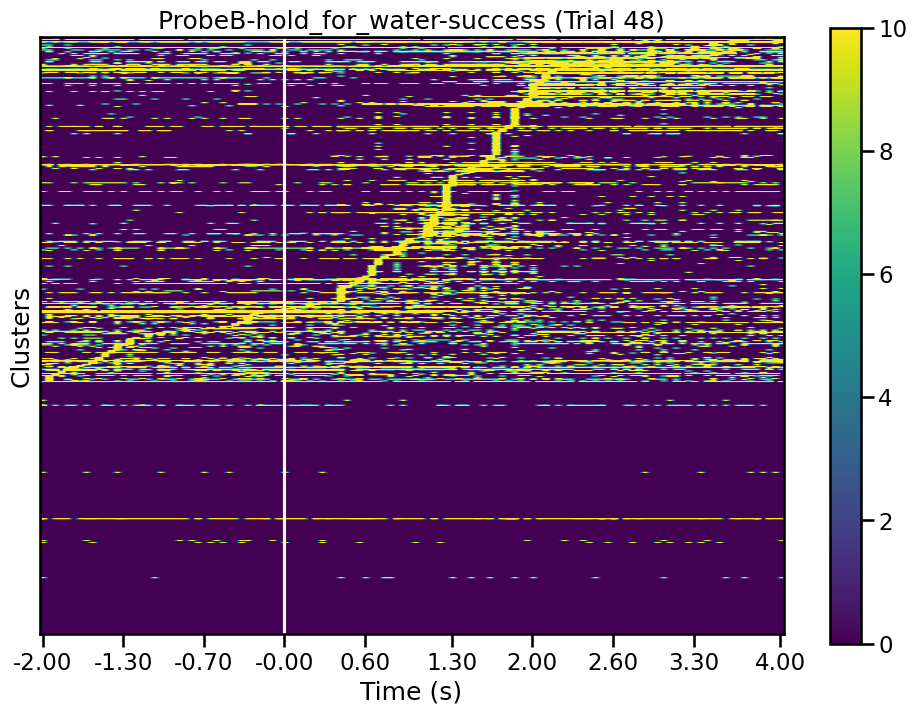

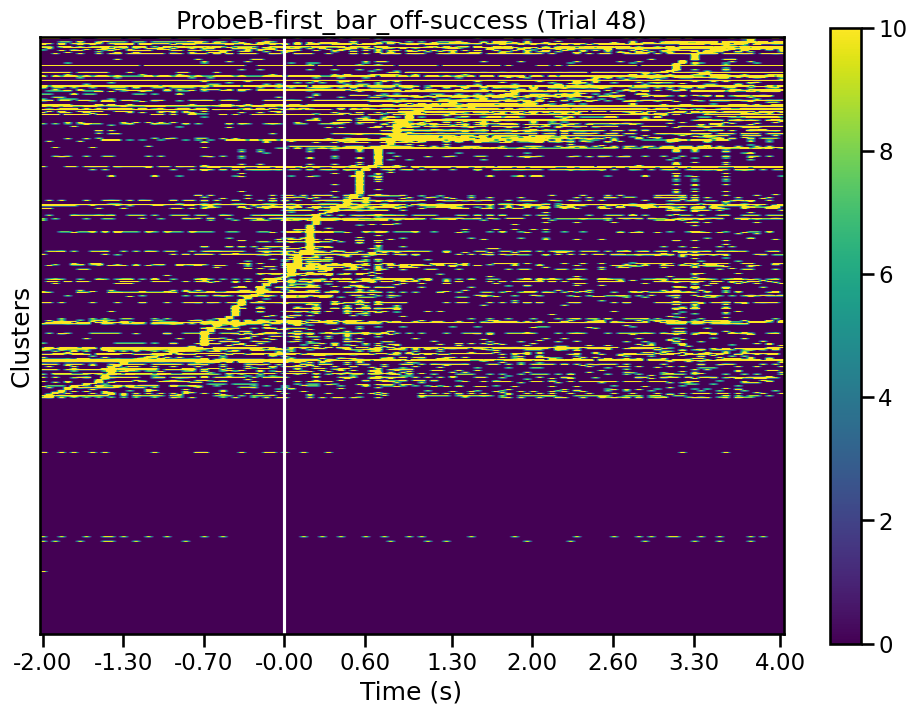

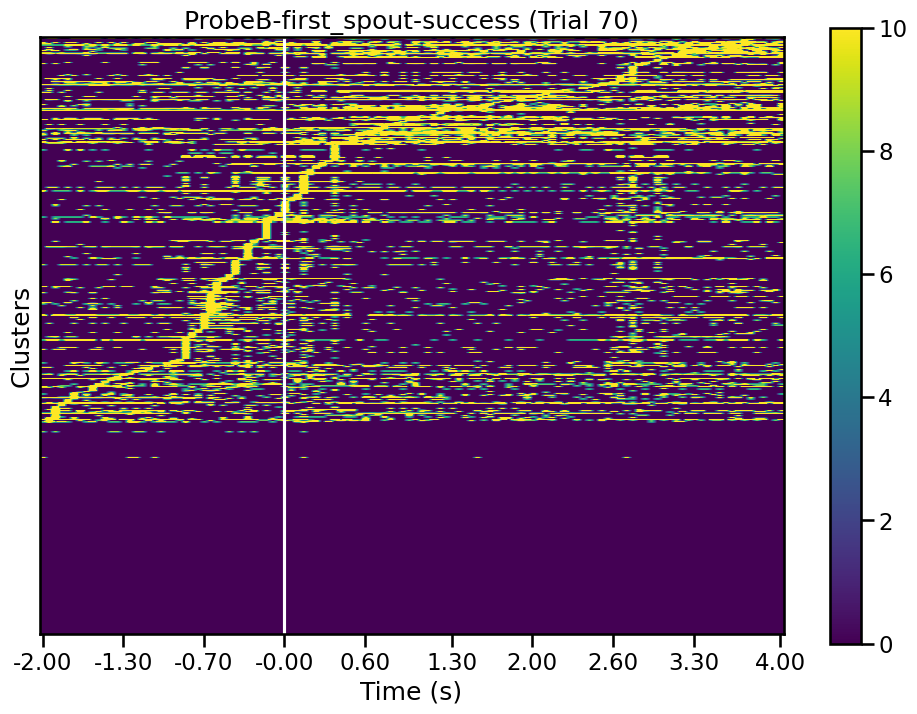

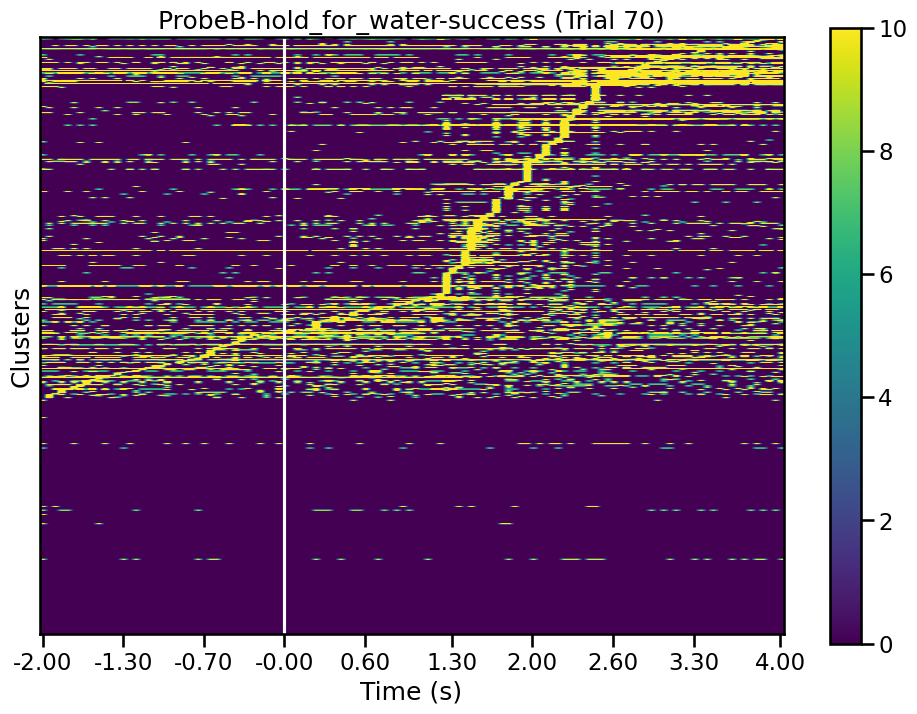

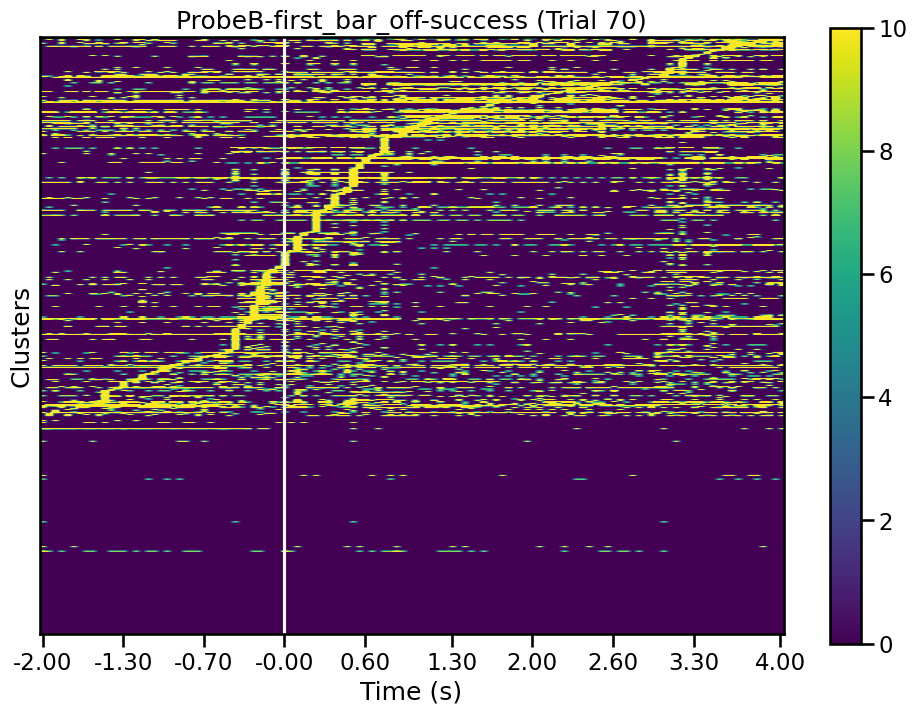

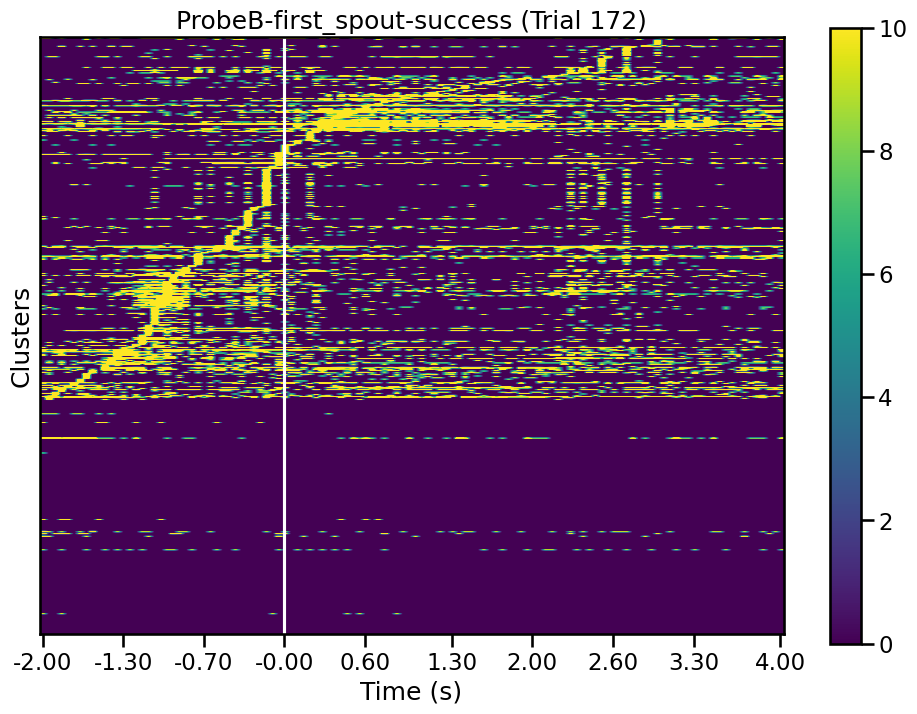

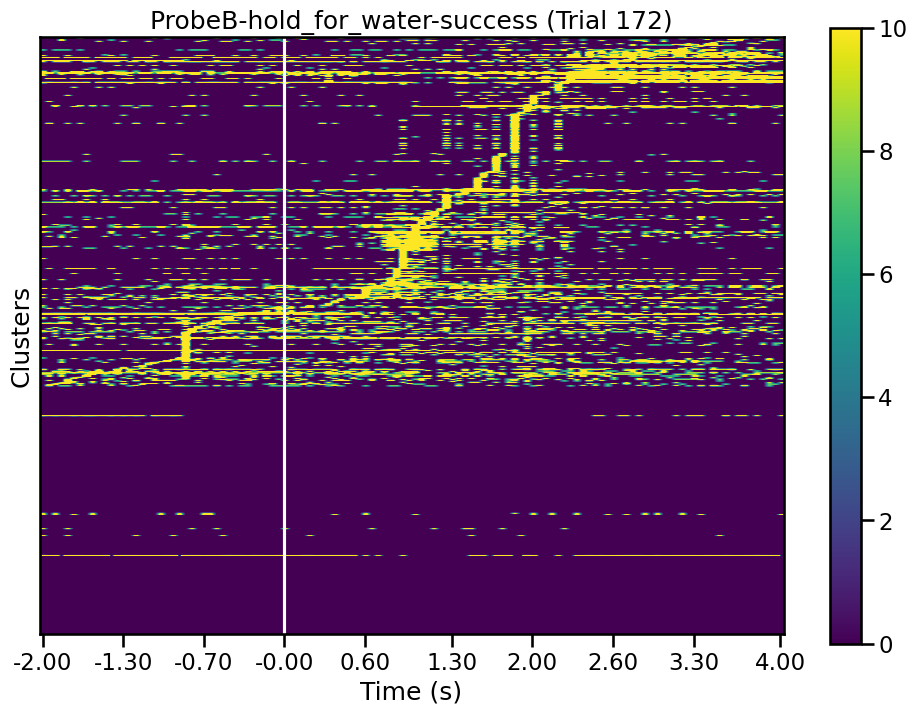

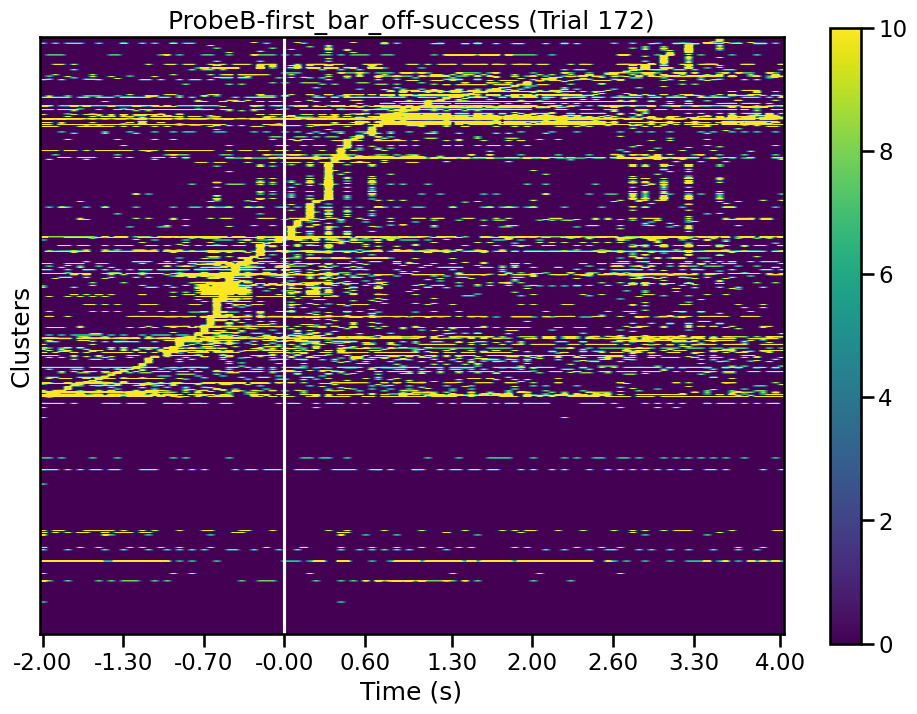

In [161]:
var2plot = ['first_spout','hold_for_water','first_bar_off']
trial_nos = [48,70,172]
is_save = True

for trial_no in trial_nos:
    sort_idx= None
    for v in var2plot:
        fig, ax, sort_idx = plot_rate_map(dataset[v+'_spike_rate'].data[trial_no,:,:], xlabels,  'Clusters', 0,  do_align_peak=True, sort_idx=None)
        success = dataset.success[0,trial_no]
        if success:
            success_text = 'success'
        else:
            success_text = 'failed'

        ax.set_title(sel_probe+f'-{v}-{success_text} (Trial {trial_no})')
        if is_save:
            fig.savefig(figure_output/f'{sel_probe}_{v}_trial_{trial_no}_sorted.png', dpi=300)

### Average data

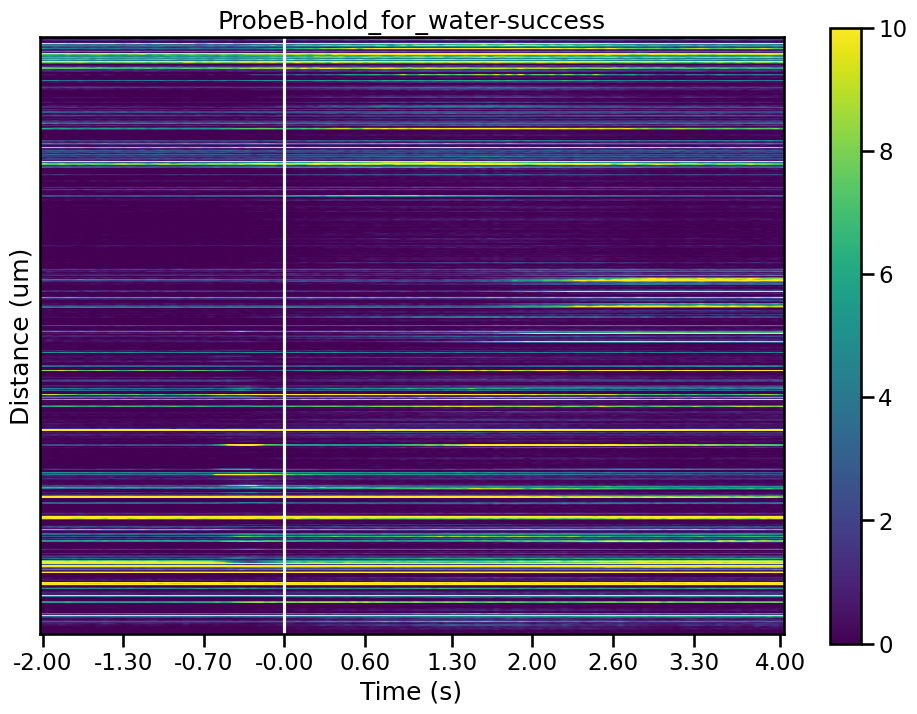

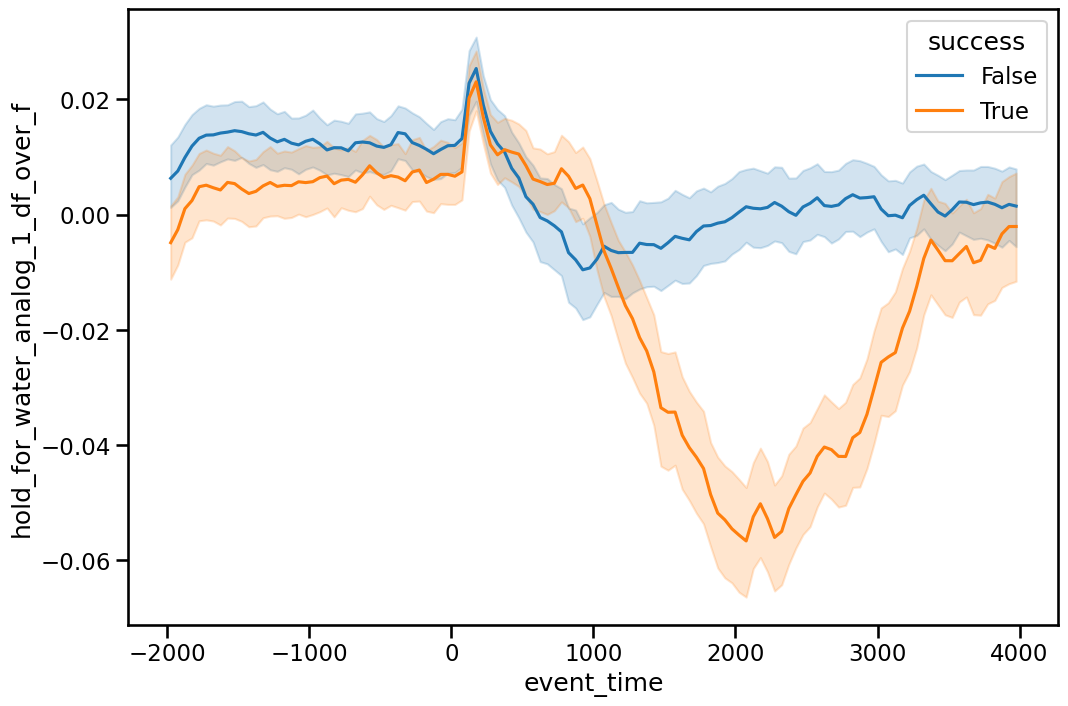

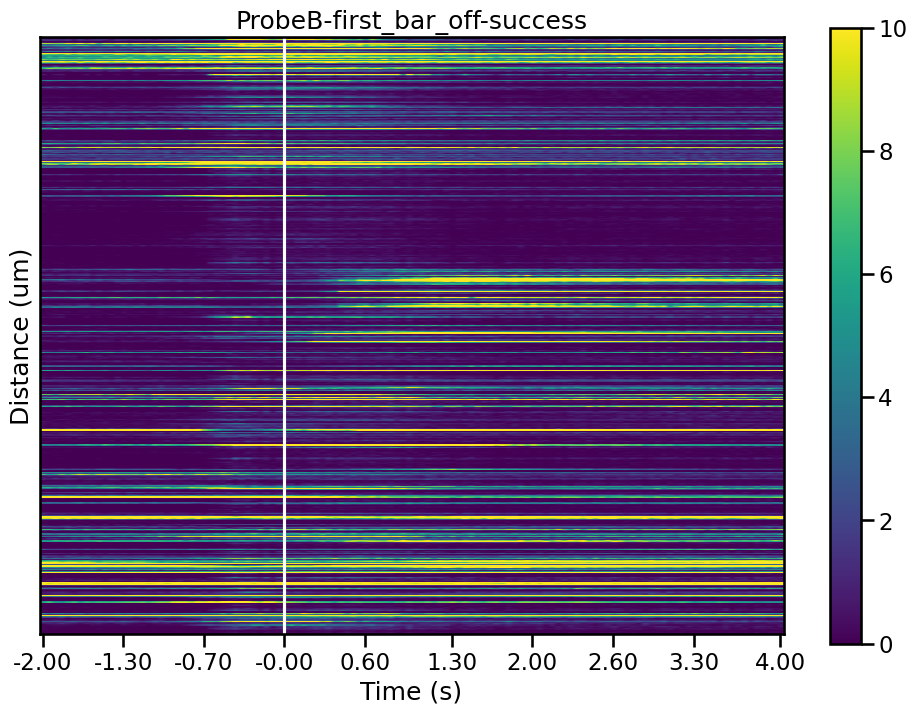

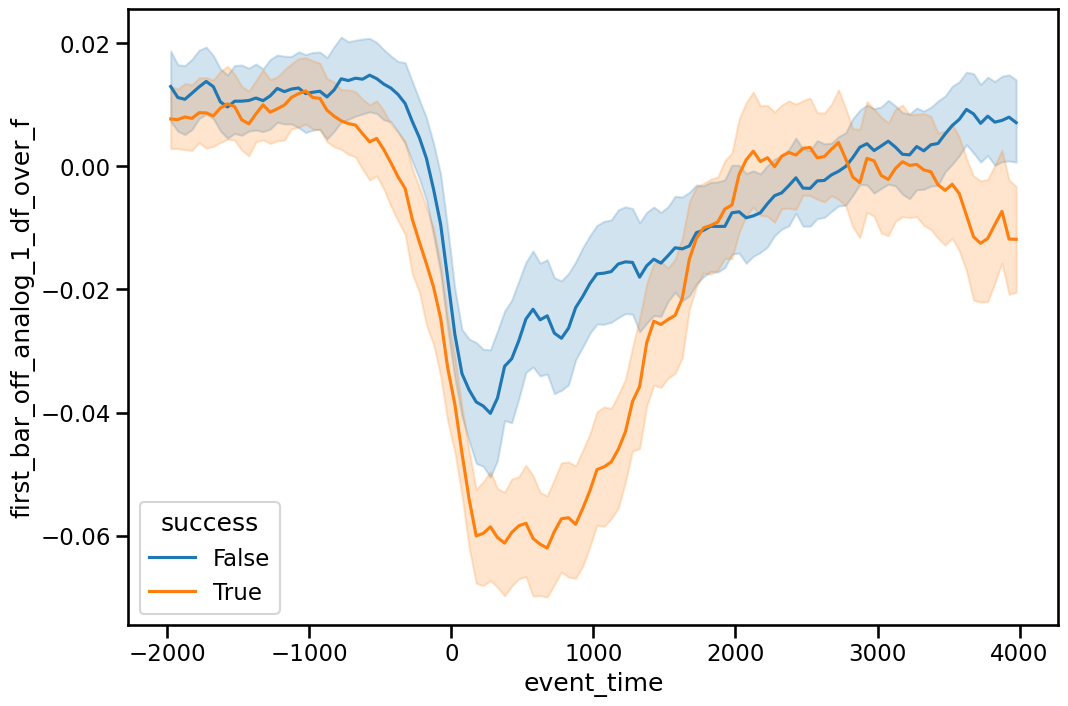

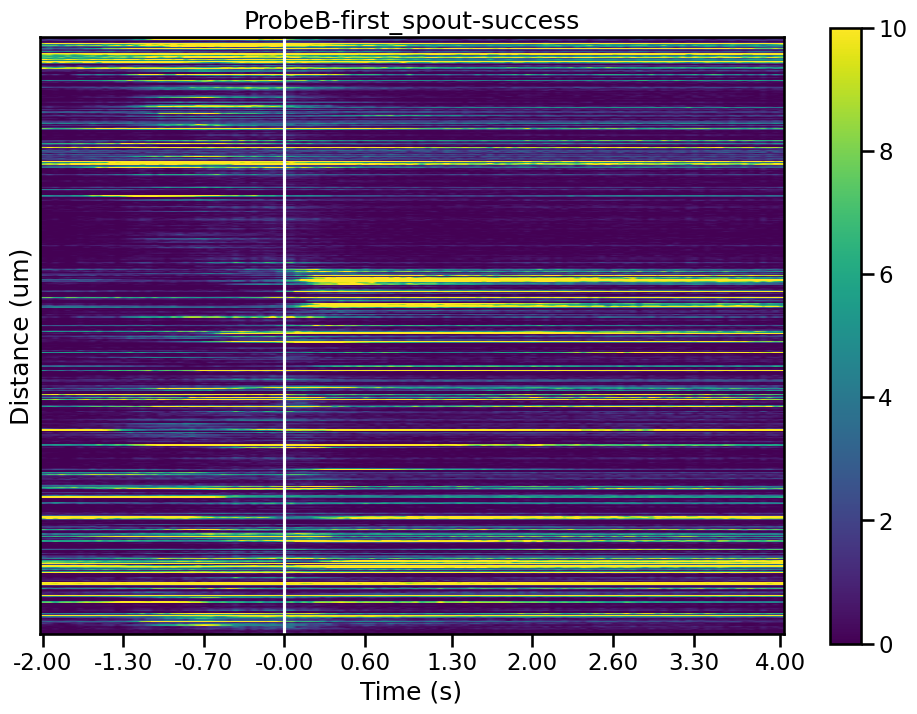

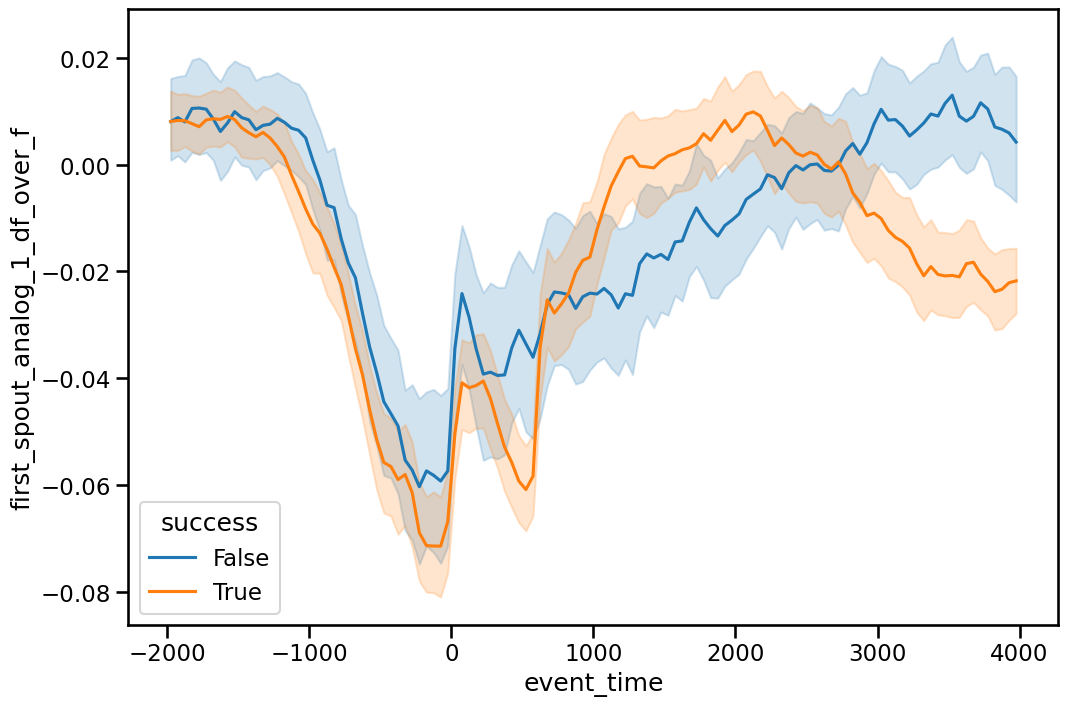

In [165]:
var2plot = ['hold_for_water', 'first_bar_off', 'first_spout']
is_save = False
for v in var2plot:
    rates = np.nanmean(dataset[v+'_spike_rate'].data, axis=0)
    fig, ax = plot_rate_map(rates, xlabels, 'Distance (um)',  0)
    success = dataset.success[0,trial_no]
    if success:
        success_text = 'success'
    else:
        success_text = 'failed'

    ax.set_title(sel_probe+f'-{v}-{success_text}')
    if is_save:
        fig.savefig(figure_output/f'{sel_probe}_{v}_average.png', dpi=300)


    #also plot the dlight signal for comparison
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    df2plot = dataset[[v+'_analog_1_df_over_f','success']].to_dataframe().reset_index()
    sns.lineplot(x = 'event_time', y=v+'_analog_1_df_over_f', hue='success', data=df2plot, ax=ax)

    if is_save:
        fig.savefig(figure_output/f'dlight_{v}_trial_average.png', dpi=300)

<Axes: xlabel='event_time', ylabel='hold_for_water_analog_1_df_over_f'>

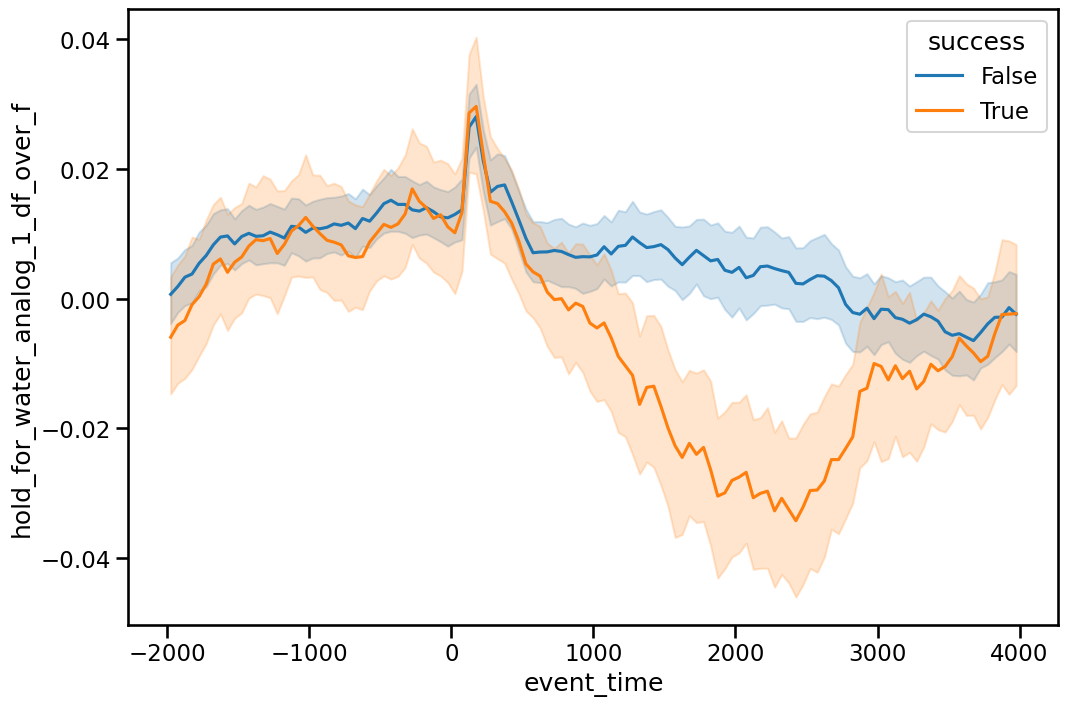

In [57]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(12,8))

df2plot = dataset[['hold_for_water_analog_1_df_over_f','success']].to_dataframe().reset_index()

sns.lineplot(x = 'event_time', y='hold_for_water_analog_1_df_over_f', hue='success', data=df2plot, ax=ax)
fig.savefig(figure_output/'photometry